In [4]:
import pandas as pd

# Import the aranet4 data
aranet4 = pd.read_csv('../datasets/aranet4.csv')

# Create a dictionary for renaming the columns
rename_dict = {
    'Carbon dioxide(ppm)': 'CO2',
    'Temperature(°F)': 'Temperature',
    'Relative humidity(%)': 'Humidity',
    'Atmospheric pressure(hPa)': 'Pressure'
}

# Rename the columns
aranet4.rename(columns=rename_dict, inplace=True)
# Convert 'Date' and 'Datetime' columns to datetime objects
aranet4['Date'] = pd.to_datetime(aranet4['Date'])
aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])

# Extract features from 'Date' and 'Datetime'
aranet4['Year'] = aranet4['Date'].dt.year
aranet4['Month'] = aranet4['Date'].dt.month
aranet4['Day'] = aranet4['Date'].dt.day
aranet4['Hour'] = aranet4['Datetime'].dt.hour
aranet4['Minute'] = aranet4['Datetime'].dt.minute
aranet4['Second'] = aranet4['Datetime'].dt.second

# Calculate the 5-minute moving average of 'Humidity'
aranet4['Humidity_MA_5'] = aranet4['Humidity'].rolling(window=5, min_periods=1).mean()

# Replace missing 'Humidity' values with the moving average
aranet4['Humidity'].fillna(aranet4['Humidity_MA_5'], inplace=True)

# Replace any remaining NaN values with the overall mean
aranet4['Humidity'].fillna(aranet4['Humidity'].mean(), inplace=True)

# Drop the moving average column
aranet4.drop('Humidity_MA_5', axis=1, inplace=True)

def report_nan(df):
    return df.isnull().sum()

# Use the function on your DataFrame
print(report_nan(aranet4))
aranet4.info()


CO2               0
Temperature       0
Humidity          0
Pressure       2522
Date              0
Time              0
Datetime          0
Year              0
Month             0
Day               0
Hour              0
Minute            0
Second            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97857 entries, 0 to 97856
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CO2          97857 non-null  int64         
 1   Temperature  97857 non-null  float64       
 2   Humidity     97857 non-null  float64       
 3   Pressure     95335 non-null  float64       
 4   Date         97857 non-null  datetime64[ns]
 5   Time         97857 non-null  object        
 6   Datetime     97857 non-null  datetime64[ns]
 7   Year         97857 non-null  int64         
 8   Month        97857 non-null  int64         
 9   Day          97857 non-null  int64         
 10  Hour         97857 non-nu

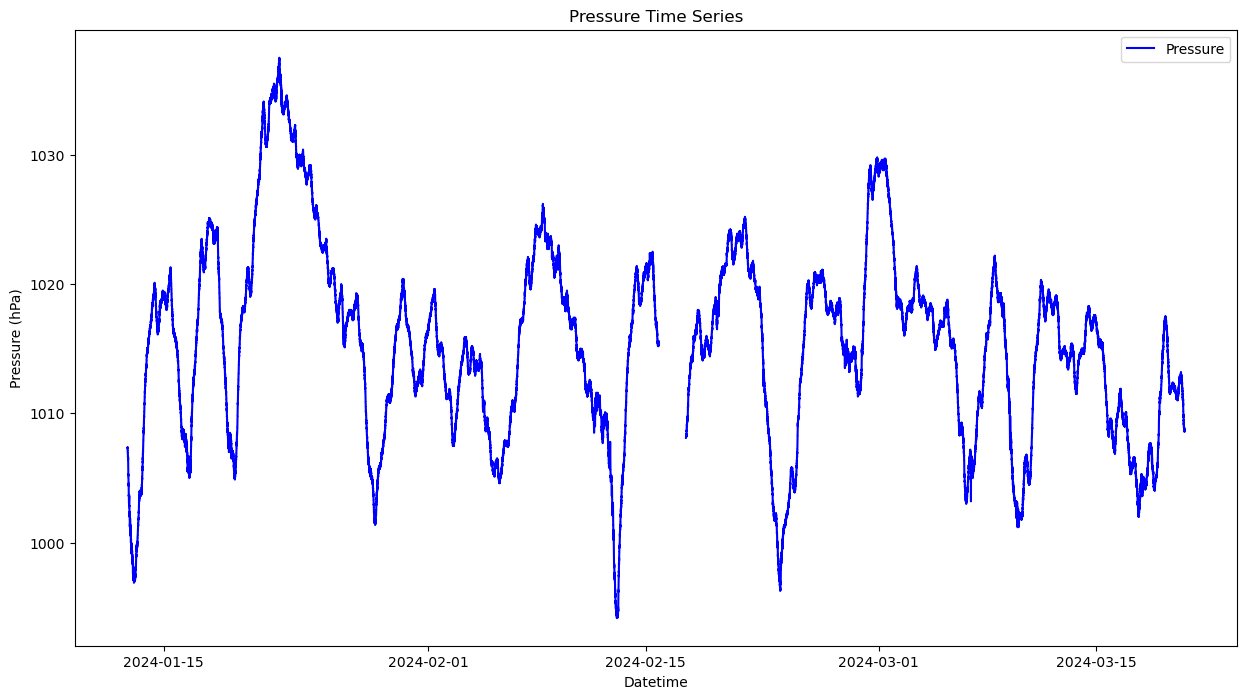

In [3]:
import matplotlib.pyplot as plt

# Assuming aranet4 is your original DataFrame and it has 'Datetime' and 'Pressure' columns

# Set the 'Datetime' column as the index if it's not already
# aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])
aranet4.set_index('Datetime', inplace=True)

# Simple time series plot of 'Pressure' against 'Datetime'
plt.figure(figsize=(15, 8))
plt.plot(aranet4.index, aranet4['Pressure'], label='Pressure', color='blue')
plt.xlabel('Datetime')
plt.ylabel('Pressure (hPa)')
plt.title('Pressure Time Series')
plt.legend()
plt.show()


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Convert 'Datetime' to datetime type
aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])

# Create time-based features
aranet4['Hour'] = aranet4['Datetime'].dt.hour
aranet4['DayOfWeek'] = aranet4['Datetime'].dt.dayofweek

# Create lag, diff, and moving average features for each original feature
for feature in ['CO2', 'Temperature', 'Humidity']:
    aranet4[f'{feature}_Lag1'] = aranet4[feature].shift(1)
    aranet4[f'{feature}_Diff1'] = aranet4[feature].diff()
    aranet4[f'{feature}_MA3'] = aranet4[feature].rolling(window=3).mean()

# Drop rows with NaN values created by lag and moving average calculations
aranet4.dropna(inplace=True)

# Split the data into sets with and without missing values for 'Pressure'
pressure_data = aranet4.dropna(subset=['Pressure']).copy()

# Define the time span for the test set (e.g., the last 2 days of the dataset)
end_date = pressure_data['Datetime'].max()
start_date = end_date - pd.Timedelta(days=2)

# Split the pressure_data into training and test sets based on the time span
train_set = pressure_data[pressure_data['Datetime'] < start_date].copy()
test_set = pressure_data[(pressure_data['Datetime'] >= start_date) & (pressure_data['Datetime'] <= end_date)].copy()

# Define features and target for the linear regression model
features = ['CO2', 'Temperature', 'Humidity', 'Hour', 'DayOfWeek',
            'CO2_Lag1', 'CO2_Diff1', 'CO2_MA3',
            'Temperature_Lag1', 'Temperature_Diff1', 'Temperature_MA3',
            'Humidity_Lag1', 'Humidity_Diff1', 'Humidity_MA3', 
            'Month','Day','Hour','Minute'] 
target = 'Pressure'

# Train the linear regression model
model = LinearRegression()
model.fit(train_set[features], train_set[target])

# Evaluate the model on the test set
test_predictions = model.predict(test_set[features])
test_mse = mean_squared_error(test_set[target], test_predictions)
test_rmse = np.sqrt(test_mse)
print(f'Test RMSE: {test_rmse}')




Test RMSE: 6.377823333009299


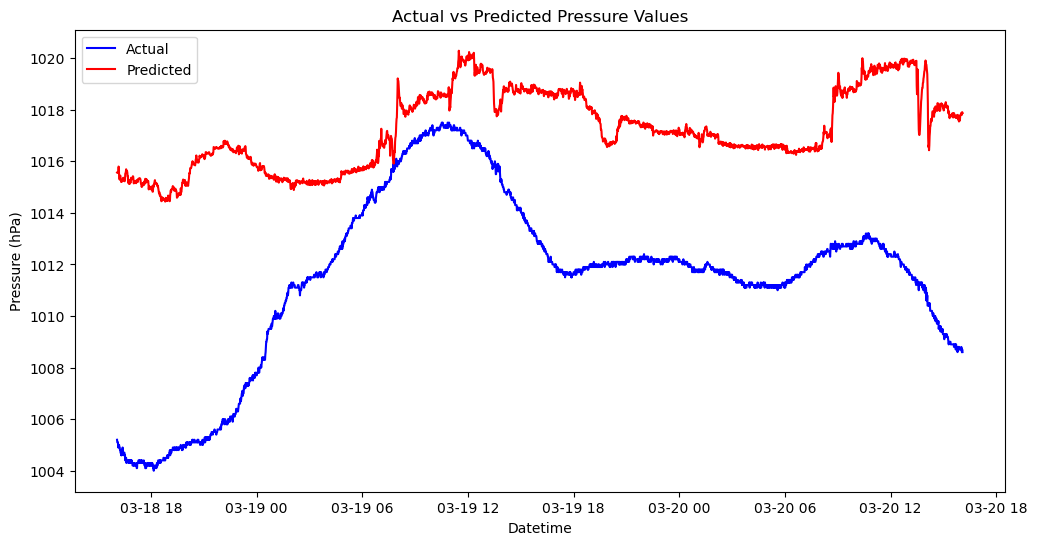

In [6]:
import matplotlib.pyplot as plt

# Plot the actual values
plt.figure(figsize=(12, 6))
plt.plot(test_set['Datetime'], test_set['Pressure'], label='Actual', color='blue')

# Plot the predicted values
plt.plot(test_set['Datetime'], test_predictions, label='Predicted', color='red')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Pressure (hPa)')
plt.title('Actual vs Predicted Pressure Values')

# Add a legend
plt.legend()

# Show the plot
plt.show()



In [7]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, train_set[features], train_set[target], cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())
print(f'Cross-validated RMSE: {cv_rmse}')

# Make predictions on the test set
test_predictions = model.predict(test_set[features])

# Calculate the RMSE and R-squared on the test set
test_rmse = np.sqrt(mean_squared_error(test_set[target], test_predictions))
test_r2 = r2_score(test_set[target], test_predictions)
print(f'Test RMSE: {test_rmse}')
print(f'Test R-squared: {test_r2}')




Cross-validated RMSE: 8.246365617813172
Test RMSE: 6.377823333009299
Test R-squared: -2.5140464215056353


c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Datetime
2024-02-24 19:37:15    1009.507538
2024-02-24 19:38:15    1009.550910
2024-02-24 19:39:15    1009.549848
2024-02-24 19:40:15    1009.499600
2024-02-24 19:41:15    1009.649707
                          ...     
2024-02-25 01:19:15    1013.699567
2024-02-25 01:20:15    1013.799674
2024-02-25 01:21:15    1013.749593
2024-02-25 01:22:15    1013.749593
2024-02-25 01:23:15    1013.799674
Name: predicted_mean, Length: 347, dtype: float64


C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_53628\3251270187.py:48: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_idx = aranet4.index.get_loc(start_date, method='nearest')
C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_53628\3251270187.py:49: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_idx = aranet4.index.get_loc(end_date, method='nearest')


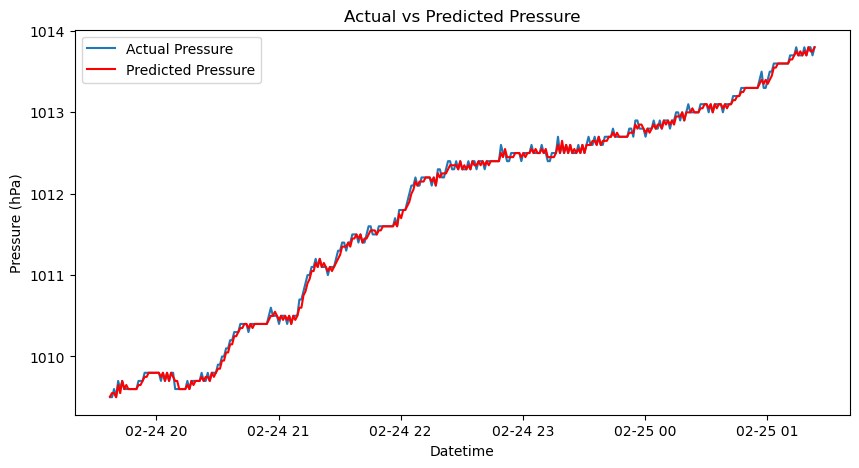

In [43]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

# Ensure the index is a DatetimeIndex
if 'Datetime' in aranet4.columns:
    aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])
    aranet4.set_index('Datetime', inplace=True)
else:
    # If the Datetime column does not exist, raise an error
    raise KeyError("The 'Datetime' column does not exist in the DataFrame.")

# Set the frequency of the DatetimeIndex to minute-wise
aranet4 = aranet4.asfreq('T')

# Generate the lag, diff, and moving average features for 'Pressure'
# For simplicity, we'll create a 1-period lag and a rolling average over the past 3 minutes
aranet4['Pressure_Lag1'] = aranet4['Pressure'].shift(1)
aranet4['Pressure_MA3'] = aranet4['Pressure'].rolling(window=3).mean()

# Define the target variable
target = 'Pressure'
# Select your exogenous variables, which might include lags and moving averages you've created
exog_vars = ['Pressure_Lag1', 'Pressure_MA3']

# Drop rows with missing values in the target or exogenous variables
aranet4.dropna(subset=[target] + exog_vars, inplace=True)

# Define the SARIMAX model (adjusting order and seasonal_order as needed)
model = SARIMAX(aranet4[target], exog=aranet4[exog_vars], order=(1, 0, 0))

# Fit the model
results = model.fit()

# Define start and end dates for prediction within the dataset's range
start_date = '2024-02-18 00:00:00'
end_date = '2024-02-25 08:04:15'

# Convert start and end dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

# Ensure the prediction range is within the index bounds
if start_date < aranet4.index.min() or end_date > aranet4.index.max():
    raise ValueError("The prediction range is outside the available data index.")

# Find the closest timestamp in the index to the desired start and end dates
start_idx = aranet4.index.get_loc(start_date, method='nearest')
end_idx = aranet4.index.get_loc(end_date, method='nearest')

# Make predictions
predictions = results.predict(start=start_idx, end=end_idx, exog=aranet4[exog_vars].iloc[start_idx:end_idx+1], dynamic=True)

# Print or plot the predictions as needed
print(predictions)

# Optionally, plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(aranet4.loc[start_date:end_date].index, aranet4.loc[start_date:end_date][target], label='Actual Pressure')
plt.plot(predictions.index, predictions, label='Predicted Pressure', color='red')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Pressure (hPa)')
plt.title('Actual vs Predicted Pressure')
plt.show()




c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Datetime
2024-02-24 19:35:15    1015.264407
2024-02-24 19:36:15    1009.384479
2024-02-24 19:37:15    1009.670223
2024-02-24 19:38:15    1009.537817
2024-02-24 19:39:15    1009.859850
                          ...     
2024-02-25 01:19:15    1013.560014
2024-02-25 01:20:15    1013.590592
2024-02-25 01:21:15    1013.709538
2024-02-25 01:22:15    1013.910252
2024-02-25 01:23:15    1013.545684
Name: predicted_mean, Length: 349, dtype: float64


c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_33576\1558651354.py:56: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  start_idx = aranet4_copy.index.get_loc(start_date, method='nearest')
C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_33576\1558651354.py:57: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end_idx = aranet4_copy.index.get_loc(end_date, method='nearest')


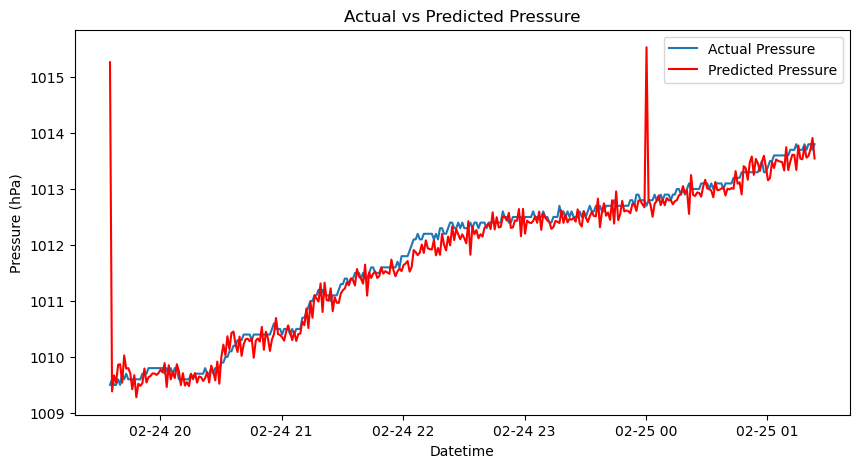

In [9]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
aranet4_copy = aranet4.copy()

# Ensure the index is a DatetimeIndex
# Check if 'Datetime' column exists and set it as an index without deleting the column
if 'Datetime' in aranet4_copy.columns and not isinstance(aranet4_copy.index, pd.DatetimeIndex):
    aranet4_copy['Datetime'] = pd.to_datetime(aranet4_copy['Datetime'])
    aranet4_copy.set_index('Datetime', inplace=True, drop=False)
else:
    # If the Datetime column does not exist, raise an error
    raise KeyError("The 'Datetime' column does not exist in the DataFrame.")

# Set the frequency of the DatetimeIndex to minute-wise
aranet4_copy = aranet4_copy.asfreq('T')

# Define the target variable
target = 'Pressure'

# Select exogenous variables which do not have NaNs in the same places as target
exog_vars = ['CO2', 'Temperature', 'Humidity',
             'Hour', 'DayOfWeek']

# Ensure there are no missing values in the exogenous variables
# If there are, you need to handle them appropriately, possibly with forward fill
aranet4_copy[exog_vars] = aranet4_copy[exog_vars].fillna(method='ffill')

# Drop rows with missing target values
aranet4_copy.dropna(subset=[target], inplace=True)

# Define the SARIMAX model
# Assuming no differencing is needed as we're using exogenous variables
# The order (p,d,q) is set to (1,0,0) for simplicity, but should be adjusted based on model diagnostics
model = SARIMAX(aranet4_copy[target], exog=aranet4_copy[exog_vars], order=(1, 0, 0))

# Fit the model
results = model.fit()

# Define start and end dates for prediction within the dataset's range
start_date = '2024-02-18 00:00:00'
end_date = '2024-02-25 08:04:15'

# Convert start and end dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

# Ensure the prediction range is within the index bounds
if start_date < aranet4_copy.index.min() or end_date > aranet4_copy.index.max():
    raise ValueError("The prediction range is outside the available data index.")

# Find the closest timestamp in the index to the desired start and end dates
start_idx = aranet4_copy.index.get_loc(start_date, method='nearest')
end_idx = aranet4_copy.index.get_loc(end_date, method='nearest')

# Make predictions
# Ensure the exogenous variables are provided for the prediction range
predictions = results.predict(start=start_idx, end=end_idx, exog=aranet4_copy[exog_vars].iloc[start_idx:end_idx+1])

# Print or plot the predictions as needed
print(predictions)

# Optionally, plot the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(aranet4_copy.loc[start_date:end_date, target], label='Actual Pressure')
plt.plot(predictions.index, predictions, label='Predicted Pressure', color='red')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Pressure (hPa)')
plt.title('Actual vs Predicted Pressure')
plt.show()





In [10]:
import pandas as pd
nan_count = aranet4.isna().sum()
print(nan_count)
# Find the largest consistent set of missing records for 'Pressure'
missing_pressure = aranet4['Pressure'].isna()
missing_blocks = (missing_pressure != missing_pressure.shift()).cumsum()[missing_pressure]
largest_missing_set = missing_blocks.value_counts().max()

largest_missing_set

first_date = missing_blocks.index.min()
last_date = missing_blocks.index.max()

print(first_date, last_date)

first_date = aranet4.iloc[49208]['Datetime']
print(first_date)
last_date = aranet4.iloc[52663]['Datetime']
print(last_date)

CO2                  0
Temperature          0
Humidity             0
Pressure             0
Date                 0
Time                 0
Datetime             0
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
DayOfWeek            0
CO2_Lag1             0
CO2_Diff1            0
CO2_MA3              0
Temperature_Lag1     0
Temperature_Diff1    0
Temperature_MA3      0
Humidity_Lag1        0
Humidity_Diff1       0
Humidity_MA3         0
dtype: int64
nan nan
2024-02-17 14:19:20
2024-02-19 23:55:00


In [11]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming aranet4 is your original DataFrame

# Ensure the index is a DatetimeIndex and set it without dropping the column
# aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])
aranet4.set_index('Datetime', inplace=True)

# Define the target variable and the exogenous variables
target = 'Pressure'
exog_vars = ['CO2', 'Temperature', 'Humidity']

# Make sure we do not forward fill the target variable 'Pressure'
# Only forward fill the exogenous variables
aranet4[exog_vars] = aranet4[exog_vars].fillna(method='ffill')

# Keep only the non-NaN records of the target for fitting the model
non_nan_records = aranet4[target].notna()

# Define and fit the SARIMAX model on non-NaN records
model = SARIMAX(aranet4.loc[non_nan_records, target], exog=aranet4.loc[non_nan_records, exog_vars], order=(1, 0, 0))
results = model.fit()


c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Corey Dearing\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


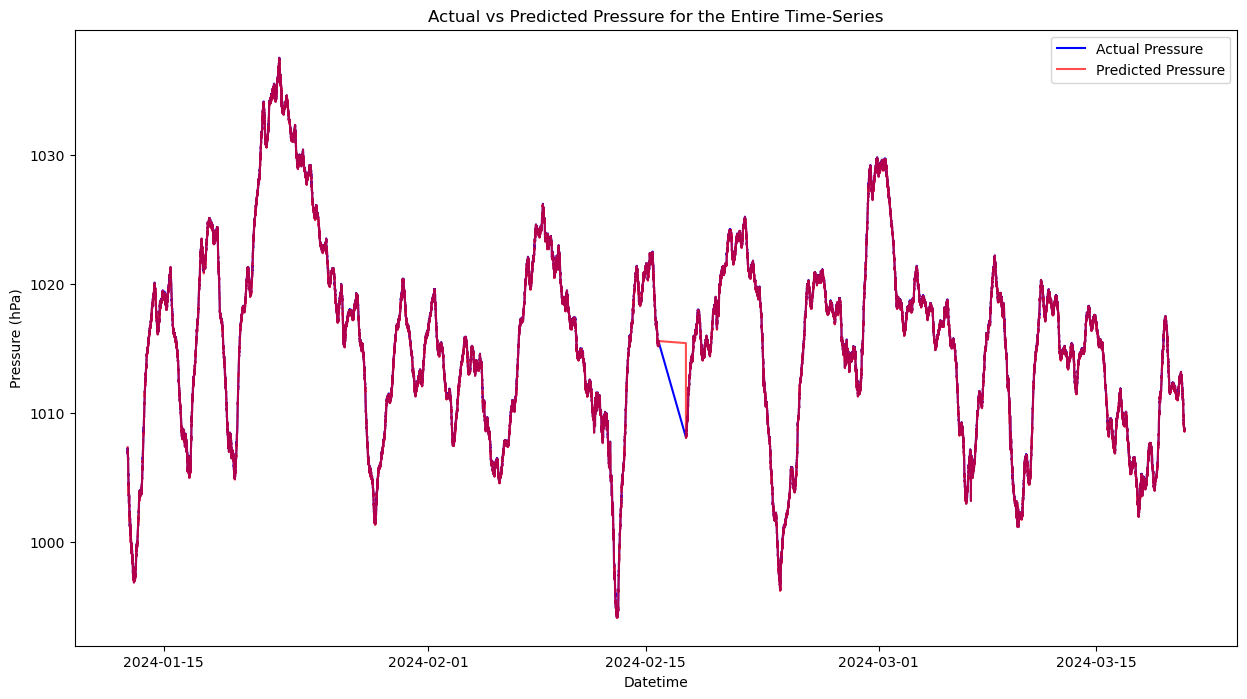

In [12]:
# Assuming results is your fitted SARIMAX model results
predictions = results.get_prediction(exog=aranet4[exog_vars])
predicted_mean = predictions.predicted_mean

# Drop the first record from the predictions
predicted_mean = predicted_mean.drop(predicted_mean.index[0])
# Drop the first record from the actual data to align with the predictions
aranet4 = aranet4.drop(aranet4.index[0])

# Plotting the actual vs predicted values for the entire time-series
plt.figure(figsize=(15, 8))
plt.plot(aranet4[target], label='Actual Pressure', color='blue')
plt.plot(predicted_mean, label='Predicted Pressure', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Pressure (hPa)')
plt.title('Actual vs Predicted Pressure for the Entire Time-Series')
plt.show()


